# 导入包读取数据


In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [2]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [4]:
train_df['tweet'] = train_df['text']

# 数据预处理

## 数据概况

数据来源于 Kaggle NLP 竞赛 [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview)。
任务为根据给定的 twitter 推文文本，判断该推文是否与灾难相关，因此本任务为文本分类任务。

根据读取结果，train 和 test 文件共包含 10876 条推文，其中 train 约占 70%。数据中存在推文发布地点、包含的灾难关键词。下载数据到本地后，对推文内容进行大致浏览，原始的文本存在一些问题需要处理：

1. 推文包含话题（一般为以 `#` 起始的词，形如 `#NOWPLAYING`）、电子邮件地址、提及（一般为以 `@` 起始的用户名，形如 `@ARSONISTMUSIC`），可能对判断是否与灾难相关有重要帮助。处理思路：根据模式匹配出这些信息后续单独处理。
2. 推文包含短链接（形如：`http://t.co/1ElreH1jLJ`），外部链接的短代码为 twitter 随机生成，无含义。处理思路：模式匹配从文本中去除链接，但可记录是否出现链接便于分类。
3. 推文原文包含乱码、转义字符、标点符号。处理思路：转义、去除。
4. 推文原文为原始自然文本，包含大小写多词性等。处理思路：词性还原，统一转小写。

由于后续需要对测试集进行预测并提交到 Kaggle 平台进行评估，因此后续所有的数据预处理均封装为函数，便于对测试集使用相同的处理步骤。

## 转换小写


In [5]:
train_df["text"] = train_df["text"].str.lower()
test_df["text"] = test_df["text"].str.lower()

## 话题提及数据提取

使用正则库即可实现规则匹配。邮件地址、提及部分后面往往接用户名，对句子含义无贡献，此时去除。

In [6]:
import re

def match_identifier(row,identifier):
    topic_pattern = r"{}\S+".format(identifier)
    matches = re.findall(topic_pattern, row['text'])
    return ''.join(matches)

# 提取话题数据，标识符为 '#'
train_df['topic'] = train_df.apply(match_identifier,axis=1,args='#')

# 提取提及数据，标识符为 '@'
train_df['mention'] = train_df.apply(match_identifier,axis=1,args='@')

In [7]:
def remove_mention_email(row):
    text = row['text']
    pattern_mention = re.compile(r'@\S+')
    text = re.sub(pattern_mention,' ',text)
    pattern_email = re.compile(r'[\w\.-]+@[\w\.-]+\.\w+')
    text = re.sub(pattern_email,'',text)
    return text

# 移除提及、邮件
train_df['text'] = train_df.apply(remove_mention_email,axis=1)


## 链接检测识别

twitter 中外链均为短链接形式 `http://t.co/xxxxxx`  ，数据集中仅存极少数其他域名外链，同样使用正则即可匹配。由于链接文本无意义，因此只需识别数量即可。同时从文中去掉这些链接。


In [8]:
def count_links(df):
    df['url_count'] = 0
    for index,row in df.iterrows():
        text = row['text']
        urls = re.findall(r"https?://\S+",text)
        url_count = 0
        for url in urls:
            text = text.replace(url,' ')
            url_count += 1
        df.at[index,'url_count'] = url_count
        df.at[index,'text'] = text

    return df

# 计算链接数量并从数据集中删去链接
train_df = count_links(train_df)

## 处理字符

### 移除 html 标签及转义字符

源数据在爬取时爬取到部分 html 标签及转义字符，这些字符对分类无益，在此去除。

In [9]:
from bs4 import BeautifulSoup

def remove_html(row):
    soup = BeautifulSoup(row['text'])
    text = soup.get_text()
    return text

# 移除 html
train_df['text'] = train_df.apply(remove_html,axis=1)

### 移除 unicode 乱码

源文本中存在 unicode 乱码，须去除。

In [10]:
def remove_unicode_chars(row):
    text = row['text'].encode("ascii", "ignore").decode()
    return text

# 移除 unicode
train_df['text'] = train_df.apply(remove_unicode_chars,axis=1)

### 缩写展开

源文本为真实推文，存在大量缩写，对缩写展开有利于后续识别语义。这里使用

In [11]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 10.1 MB/s eta 0:00:00


In [12]:
import contractions

# 缩写展开
train_df["text"] = train_df["text"].apply(contractions.fix)

### 去除符号

前面已经处理了包含符号的内容，接下来可以把源文本中所有的符号直接删除。

In [13]:
import string

def remove_punctuations(row):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",row['text'])
    return text

# 去除符号
train_df['text'] = train_df.apply(remove_punctuations,axis=1)

### 去除数字

In [14]:
def remove_digits(row):
    pattern = re.compile("\w*\d+\w*")
    text = re.sub(pattern, "",row['text'])
    return text

# 去除数字
train_df['text'] = train_df.apply(remove_digits,axis=1)

## 词语处理

### 去停用词

推文中有大量无实际意义的词，如介词冠词等，保留这些词不利于解析语义。这里使用 `nltk` 包进行停用词去除。

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(row):
    return " ".join([word for word in str(row['text']).split() if word not in stop_words])

# 去停用词
train_df['text'] = train_df.apply(remove_stopwords,axis=1)

### 词性还原

推文中，同一词语可能以不同时态词性出现，为便于识别语义，需对这些词进行词性还原。这里使用 `nltk` 包进行词性还原。

In [16]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(row):
    words = [lemmatizer.lemmatize(word) for word in row['text'].split()]
    text = ' '.join(words)
    return text

# 词性还原
train_df['text'] = train_df.apply(lemmatize_text,axis=1)

最终得到已清洗的文本

In [17]:
train_df[train_df.target == 1].loc[:,['text','tweet','target']].head(5)

,text,tweet,target
0,deed reason earthquake may allah forgive u,Our Deeds are the Reason of this #earthquake M...,1
1,forest fire near la ronge sask canada,Forest fire near La Ronge Sask. Canada,1
2,resident asked shelter place notified officer ...,All residents asked to 'shelter in place' are ...,1
3,people receive wildfire evacuation order calif...,"13,000 people receive #wildfires evacuation or...",1
4,got sent photo ruby alaska smoke wildfire pour...,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
train_df[train_df.target == 0].loc[:,['text','tweet','target']].tail(5)

,text,tweet,target
7581,great atmosphere british lion gig tonight hear...,@engineshed Great atmosphere at the British Li...,0
7582,cramer iger word wrecked disney stock cnbc,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,box ready explode exploding kitten finally arr...,These boxes are ready to explode! Exploding Ki...,0
7587,siren everywhere,Sirens everywhere!,0
7593,heard really loud bang everyone asleep great,I just heard a really loud bang and everyone i...,0


最后，对测试集进行同样处理。

In [19]:
test_df['tweet'] = test_df['text']
test_df['topic'] = test_df.apply(match_identifier,axis=1,args='#')# 提取话题数据
test_df['mention'] = test_df.apply(match_identifier,axis=1,args='@')# 提取提及数据
test_df['text'] = test_df.apply(remove_mention_email,axis=1)# 移除提及、邮件
test_df = count_links(test_df)# 计算链接数量并从数据集中删去链接
test_df['text'] = test_df.apply(remove_html,axis=1)# 移除 html
test_df['text'] = test_df.apply(remove_unicode_chars,axis=1)# 移除 unicode
test_df["text"] = test_df["text"].apply(contractions.fix)# 缩写展开
test_df['text'] = test_df.apply(remove_punctuations,axis=1)# 去除符号
test_df['text'] = test_df.apply(remove_digits,axis=1)# 去除数字
test_df['text'] = test_df.apply(remove_stopwords,axis=1)# 去停用词
test_df['text'] = test_df.apply(lemmatize_text,axis=1)# 词性还原

# 数据探索性分析

文本经过清洗处理后，就可以送入模型进行训练了。在这之前，还需要对数据集进行一定的探索性分析，便于了解数据集概况。

In [20]:
# 词数统计
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# 不重复词数统计
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# 标签词语统计
train_df['hashtag_count'] = train_df['topic'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['topic'].apply(lambda x: len([c for c in str(x) if c == '#']))

# 提及统计
train_df['mention_count'] = train_df['mention'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['mention'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [21]:
train_df.describe().iloc[:,1:]

,target,url_count,word_count,unique_word_count,hashtag_count,mention_count
count,7613.00000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,0.42966,0.620123,8.548010,8.309471,0.445816,0.358597
std,0.49506,0.663930,3.478251,3.324752,1.098589,0.717163
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,6.000000,6.000000,0.000000,0.000000
50%,0.00000,1.000000,9.000000,8.000000,0.000000,0.000000
75%,1.00000,1.000000,11.000000,11.000000,0.000000,1.000000
max,1.00000,4.000000,23.000000,21.000000,13.000000,8.000000


**样本标签分布**：57(非灾难):43(灾难)，较为均匀。

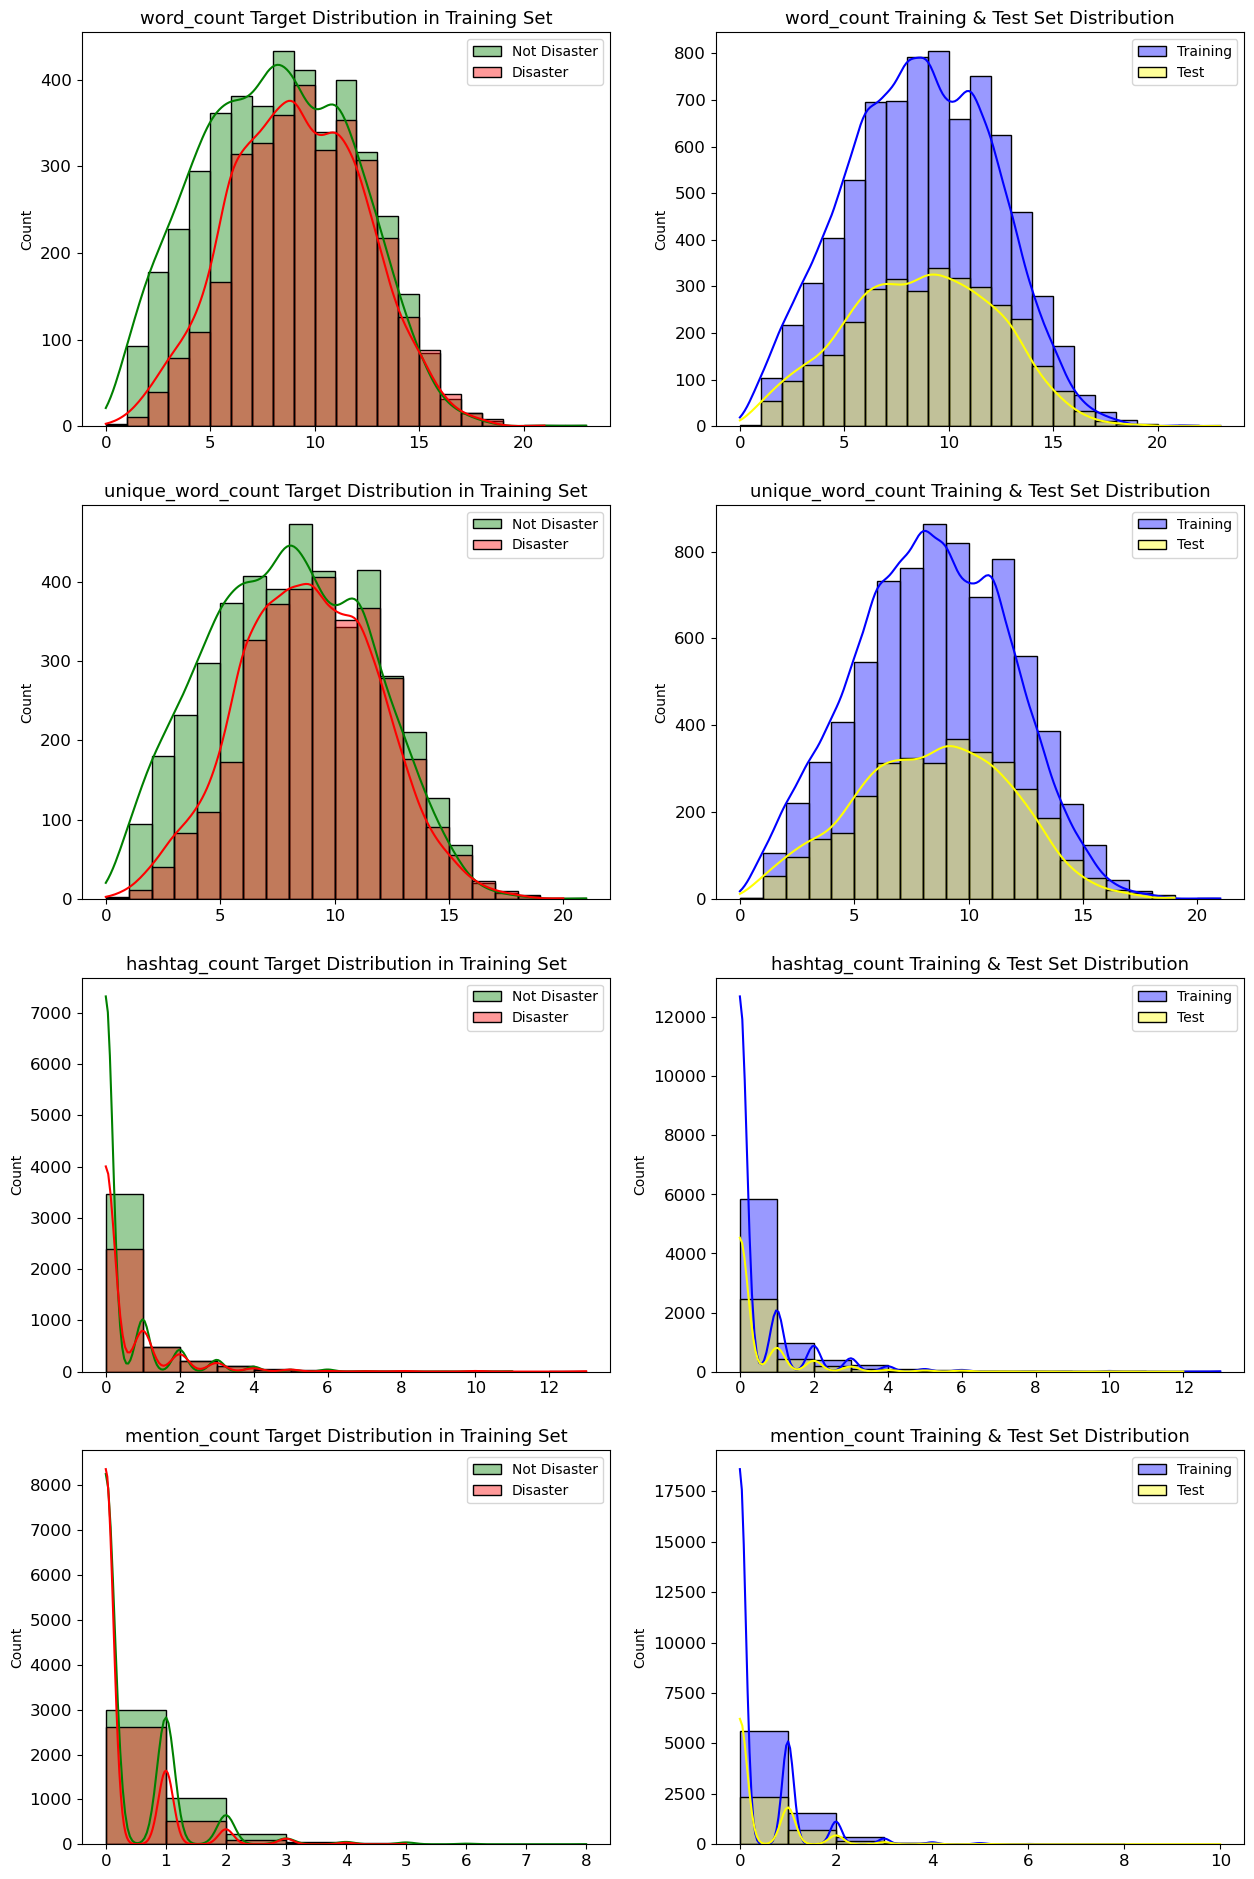

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

METAFEATURES = ['word_count', 'unique_word_count', 'hashtag_count', 'mention_count']
fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(15, 24), dpi=100)
DISASTER_TWEETS = train_df['target'] == 1
for i, feature in enumerate(METAFEATURES):
    sns.histplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green',alpha=0.4,binwidth=1,kde=True)
    sns.histplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red',alpha=0.4,binwidth=1,kde=True)
    
    sns.histplot(train_df[feature], label='Training', ax=axes[i][1], color='blue',alpha=0.4,binwidth=1,kde=True)
    sns.histplot(test_df[feature], label='Test', ax=axes[i][1], color='yellow',alpha=0.4,binwidth=1,kde=True)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

词频、不同词数量、标签词数量、提及数量上，无论是正负样本还是训练集、测试集，分布都类似。

# 建模分析：传统方法

传统方法中，只考虑 text 文本。

## Model1: Unigram + CountVectorizer + RidgeClassifier


In [23]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

count_vectorizer = feature_extraction.text.CountVectorizer()

train_vec = count_vectorizer.fit_transform(train_df["text"])

In [24]:
ridge = linear_model.RidgeClassifier()
param_grid = {'alpha': np.logspace(-3, 3, 7),
              'fit_intercept': [True, False]}
grid_search = model_selection.GridSearchCV(ridge, param_grid, cv=5, scoring='f1')

In [25]:
grid_search.fit(train_vec, train_df['target'])

GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'fit_intercept': [True, False]},
             scoring='f1')

In [26]:
grid_search.best_score_

0.6401774342859325

通过网格搜索方式对岭回归的参数进行调整。在五折交叉检验中，模型的最佳表现f1值为0.640。下面对测试集进行预测并提交到 Kaggle 进行评估。

In [27]:
grid_search.best_params_

{'alpha': 1000.0, 'fit_intercept': False}

In [28]:
clf1 = linear_model.RidgeClassifier(alpha=100,fit_intercept=True)
clf1.fit(train_vec, train_df['target'])

test_vec = count_vectorizer.transform(test_df["text"])

# sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
# sample_submission["target"] = clf1.predict(test_vec)
# sample_submission.to_csv("submission.csv", index=False)

**本次提交成绩 f1：0.78547。** 这一成绩略微超越 Kaggle 在本赛事设定的 benchmark（0.78179）。
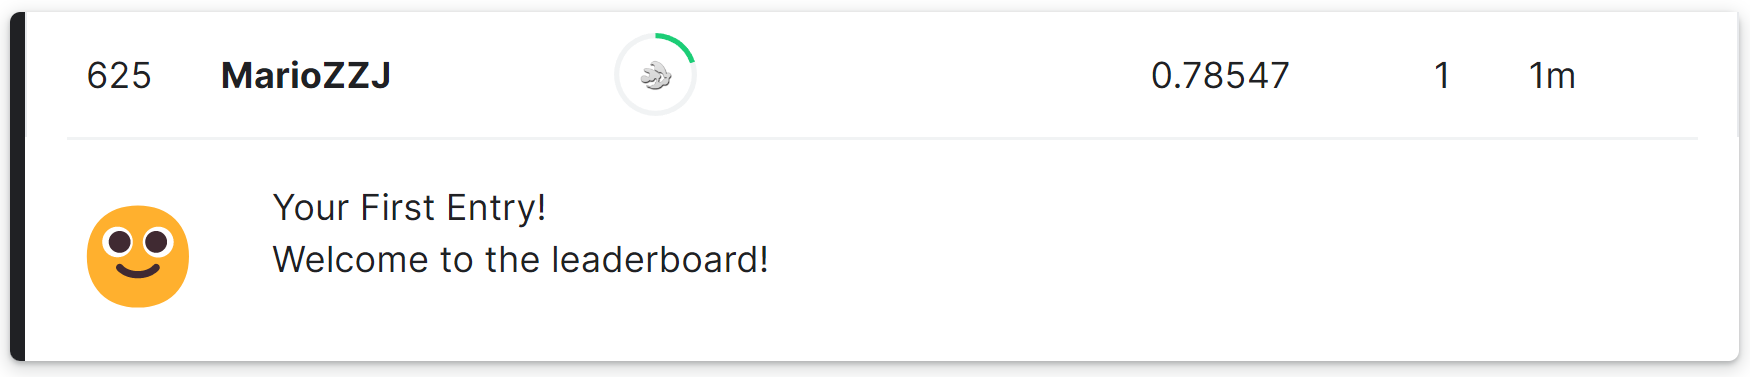
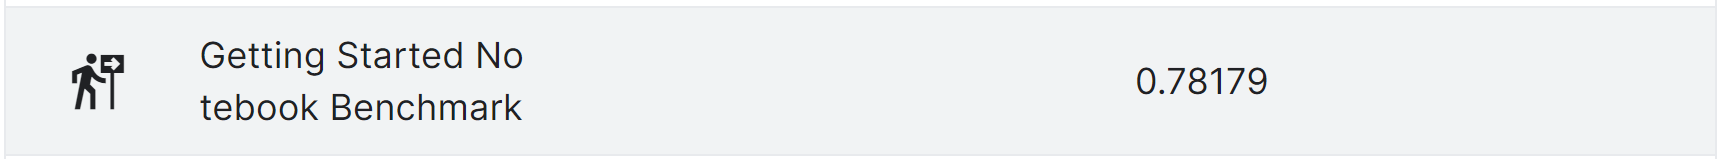

## Model2：Bigram + CountVectorizer + RidgeClassifier

In [29]:
big_vectorizer = feature_extraction.text.CountVectorizer(ngram_range=(2, 2))
train_vec_big = big_vectorizer.fit_transform(train_df['text'])

In [30]:
ridge = linear_model.RidgeClassifier()
param_grid = {'alpha': np.logspace(-3, 3, 7),
              'fit_intercept': [True, False]}
grid_search = model_selection.GridSearchCV(ridge, param_grid, cv=5, scoring='f1')
grid_search.fit(train_vec_big, train_df['target'])

GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'fit_intercept': [True, False]},
             scoring='f1')

In [31]:
grid_search.best_score_

0.45466517197727124

使用 Bigram 后，经过网格搜索的最佳性能反而下降。原因可能是样本集较小，在训练集中不能尽可能全地出现双词组合，导致对其他句子的表示能力较弱，甚至弱于 Unigram。

In [32]:
grid_search.best_params_

{'alpha': 10.0, 'fit_intercept': False}

In [33]:
clf2 = linear_model.RidgeClassifier(alpha=10,fit_intercept=False)
clf2.fit(train_vec_big, train_df['target'])

test_vec_big = big_vectorizer.transform(test_df["text"])

# sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
# sample_submission["target"] = clf2.predict(test_vec_big)
# sample_submission.to_csv("submission.csv", index=False)

**本次提交成绩f1：0.76064**，低于Model1。
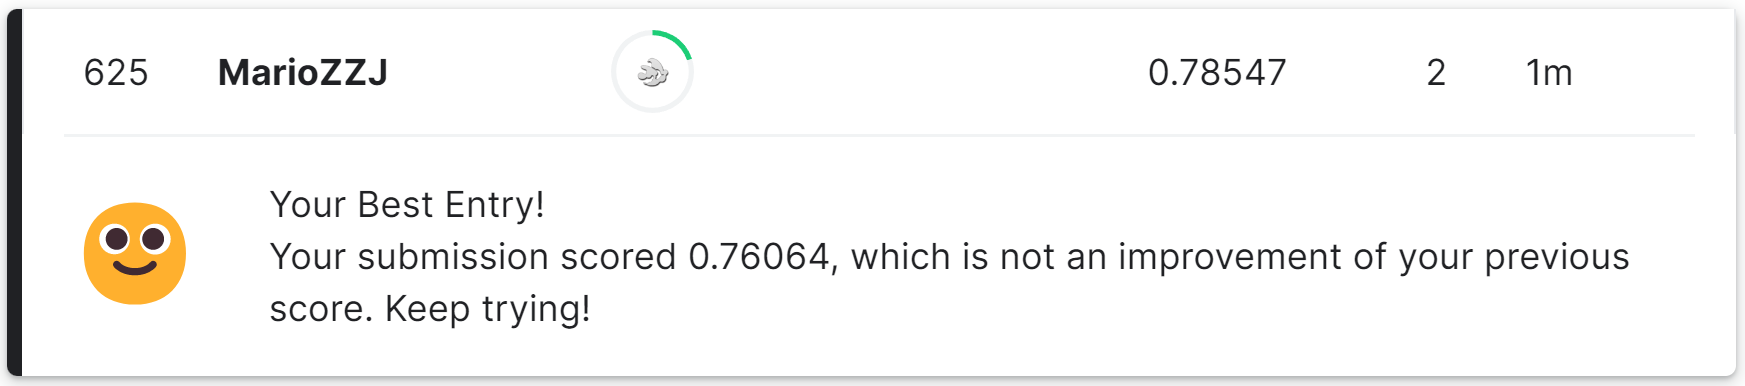

# 建模分析：深度学习方法

使用深度学习的方法，往往可以运用预训练模型对文本进行更好的表示。同时也可自行修改模型结构，融合更多的信息，优化模型的预测表现。

## 基础设置

设置好基础的深度学习环境（torch、Bert等），并调研句长便于后续配置模型结构。


In [34]:
import random
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

if torch.cuda.is_available():    
    device = torch.device('cuda')    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [35]:
combined = pd.concat([train_df, test_df]).text.values
max_len = 0
for text in combined:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('最长句长: ', max_len)

最长句长:  36


In [36]:
idx = 7613
train_text= combined[:idx]
test_text = combined[idx:]
train_text.shape

labels = train_df['target'].values

## Model3：Bert-Text

这里将使用简单的 `BertForSequenceClassification` 进行训练，会用到基于 `bert-large-uncased` 的语料的预训练模型。该模型包括基础的 Bert 模型和一个线性层，用于本题的二分类任务。

### 数据封装

In [37]:
def tokenize_map(sentence,l='None'):
    global labels
    
    input_ids = []
    attention_masks = []
    
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
                            text,                      
                            add_special_tokens = True, # 增加标签 '[CLS]' 和 '[SEP]'
                            truncation='longest_first', # 截断方式
                            max_length = 36,           # 最大长度，根据上面分析取最长
                            pad_to_max_length = True, # 长度不够的填充
                            return_attention_mask = True,
                            return_tensors = 'pt',     # 返回类型为 pytorch tensors.
                       )
        input_ids.append(encoded_dict['input_ids']) # 汇总所有句子词的id，下面mask同
        attention_masks.append(encoded_dict['attention_mask'])
    #将 list 转为 tensor
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if l != 'None': # 不带标签，即测试集
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [38]:
# 分词、匹配id
input_ids, attention_masks, labels = tokenize_map(train_text, labels)
test_input_ids, test_attention_masks= tokenize_map(test_text)

In [39]:
# 汇总训练集
dataset = TensorDataset(input_ids, attention_masks, labels)
# 拆分占 20% 的验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,090 training samples
1,523 validation samples


In [40]:
batch_size = 32

# 使用 dataloader 加载数据

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # 随机选 batch
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 验证评估时顺序无所谓
        )

In [41]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### 加载模型

`BertForSequenceClassification` 是一个预定义好的模型结构，包含 Bert 和一个线性层。

In [42]:
%%capture
model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', 
    num_labels = 2, # 二分类   
    output_attentions = False, output_hidden_states = False, 
)# 加载模型，模型含 Bert 及一个线性层

model.to(device) # 让模型加载到 GPU 上，加速运算

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

可以用 `named_parameters()` 方法查看模型结构：

In [43]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())
print('模型结构（BERT 模型参数数量 {:}）\n'.format(len(params)))
print('==== 嵌入层 ====')
for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Transformer ====')
for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== 输出层 ====')
for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

模型结构（BERT 模型参数数量 393）

==== 嵌入层 ====
bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== Transformer ====
bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (1024,)
bert.encoder.layer.0.attention.output.Laye

随后是一些训练过程的配置，包括优化器、训练轮数、调度器等。

In [44]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, 
                  eps = 1e-8 
                )

epochs = 3 # 训练轮数（Bert推荐2~4轮）
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

模型输出结果为 tensor，为此定义一些函数处理结果用于评估。

In [45]:
import time,datetime
from sklearn.metrics import f1_score, accuracy_score
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()   
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))# hh:mm:ss

接下来定义训练过程

In [46]:
training_stats = [] # 记录训练数据：损失、精准率、F1值、训练时间
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    
    model.train() # 变更模式为 train

    ### 训练
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0: # 每 50 个 Batch 汇报一次
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 转换该批结果
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)
        
        model.zero_grad()        

        # 前向传播
        r = model(b_input_ids, 
             token_type_ids=None, 
             attention_mask=b_input_mask, 
             labels=b_labels)
        loss = r.loss
        logits = r.logits
        
        # 累积损失
        total_train_loss += loss.item()

        # 反向传播
        loss.backward()

        # 为防止梯度爆炸，进行梯度剪裁
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step() # 更新参数
        scheduler.step() # 更新学习率

    # 计算总损失和时间
    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print('\n  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
        
    ### 验证集评估
    t0 = time.time()
    model.eval() # 变更模式为 evaluation
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0
    
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad(): # 验证过程中不用计算图，告知pytorch
            r = model(b_input_ids, 
                   token_type_ids=None, 
                   attention_mask=b_input_mask,
                   labels=b_labels)
            loss = r.loss
            logits = r.logits
            
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy() # 数据返回到cpu
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
        
    # 汇总本轮训练评估
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('\n总训练时间 {:} (hh:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
  Batch    50  of    191.    Elapsed: 0:00:22.
  Batch   100  of    191.    Elapsed: 0:00:44.
  Batch   150  of    191.    Elapsed: 0:01:05.

  Average training loss: 0.51
  Training epcoh took: 0:01:22
  Accuracy: 0.80
  F1: 0.35
  Validation Loss: 0.46
  Validation took: 0:00:22

======== Epoch 2 / 3 ========
  Batch    50  of    191.    Elapsed: 0:00:21.
  Batch   100  of    191.    Elapsed: 0:00:43.
  Batch   150  of    191.    Elapsed: 0:01:04.

  Average training loss: 0.40
  Training epcoh took: 0:01:21
  Accuracy: 0.82
  F1: 0.33
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 3 / 3 ========
  Batch    50  of    191.    Elapsed: 0:00:21.
  Batch   100  of    191.    Elapsed: 0:00:43.
  Batch   150  of    191.    Elapsed: 0:01:04.

  Average training loss: 0.36
  Training epcoh took: 0:01:21
  Accuracy: 0.83
  F1: 0.33
  Validation Loss: 0.41
  Validation took: 0:00:22

总训练时间 0:05:11 (hh:mm:ss)


训练完成后展示训练结果，三轮训练后损失下降，验证集表现不断上升。总耗时约5分钟。

In [47]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.51,0.46,0.80,0.35,0:01:22,0:00:22
2,0.40,0.42,0.82,0.33,0:01:21,0:00:22
3,0.36,0.41,0.83,0.33,0:01:21,0:00:22


最后，利用训练的模型对测试集进行预测：

In [48]:
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))
model.eval() # 切换模式到 evalutaion 

predictions = []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch) # 加载数据到GPU
    b_input_ids, b_input_mask, = batch
  
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    logits = outputs[0]
    
    logits = logits.detach().cpu().numpy()
    
    predictions.append(logits)

Predicting labels for 3,263 test sentences...


In [49]:
# 展平预测结果，用argmax激活函数输出最后的预测结果
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

将预测结果汇总并提交到 Kaggle：

In [50]:
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = flat_predictions
submission.to_csv('submission.csv', index=False, header=True)

**本次提交成绩f1：0.82378**，高于前面的 Model 和 Kaggle Benchmark。
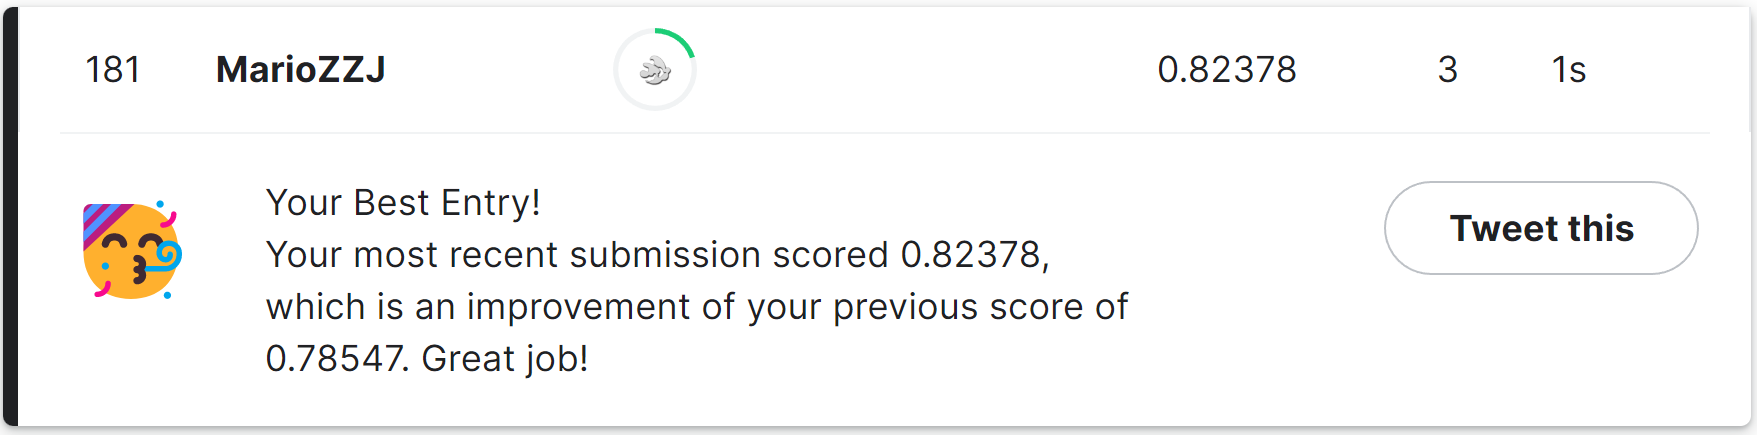

得益于 Bert 的强大表示能力，模型性能得到显著提升。

# 总结

本次竞赛过程对来自 Twitter 的过万条推文进行预处理及分析，运用多种算法进行文本分类。通过实践在一定程度上提升了模型性能和表现。最终F1绝对值在 0.82 左右，仍有一定优化空间。结合赛题讨论区留言得知，训练数据集中存在不少错误标注、重复标注数据，如需突破下一个性能瓶颈可能需要在数据清洗方面投入更多精力。

本次竞赛数据集来自原始的推文，在开头的分析中发现原始自然语言存在许多需要处理的问题，须经过一定预处理后才能交由模型进行学习训练。个人认为在自然语言处理任务中，重中之重是通过对语料的了解，同时根据后续算法的输入特征，对文本数据进行恰当的清洗，对文本数据进行恰当、巧妙的预处理对于模型性能提升可以起到事半功倍的作用。